In [1]:
import sys
sys.path.append('..')

In [2]:
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from core.dataset import *
from core.utils import *

In [3]:
path = 'D:/Data/hoffmanlab/featureselection/data/'

In [4]:
ligands = ['CpG_am', 'FLA_am', 'FSL_am', 'LPS_am', 'P3K_am', 'PIC_am', 'R84_am', 'TNF_am']
polarizations = ['', 'i0', 'i3', 'i4', 'ib', 'ig']

In [5]:
data = PolarData(path, ligands, polarizations, merge=True)

## Performance threshold analysis using features derived from models fit on individual ligands

In [6]:
cpg_tf = ['envelope_5', 'integrals_pos_83', 'integrals_57']
fla_tf = ['integrals_pos_64', 'duration_3', 'integrals_pos_15']
fsl_tf = ['integrals_pos_15', 'integrals_pos_13', 'integrals_pos_19']
lps_tf = ['power_119', 'envelope_5', 'integrals_pos_39']
p3k_tf = ['duration_4', 'median_peak_amp', 'integrals_pos_35']
pic_tf = ['integrals_pos_40', 'integrals_pos_33', 'integrals_pos_47']
r84_tf = ['integrals_pos_24', 'integrals_pos_88', 'peak2rms']
tnf_tf = ['mean_movvar', 'time_series_3', 'std_peak2trough']

In [7]:
all_tf = cpg_tf + fla_tf + fsl_tf + lps_tf + p3k_tf + pic_tf + r84_tf + tnf_tf

In [8]:
all_tf = list(set(all_tf))

## Iterative popping

In [9]:
import sklearn
from sklearn import preprocessing
from sklearn import metrics
from sklearn import model_selection

In [10]:
epochs = 20
labels = data.iloc[:, [984]].to_numpy().reshape(-1, )
n = len(all_tf)
crs = []
static_percent_res = []
seq_percent_res = []

In [11]:
for e in range(epochs):
    d = all_tf[:(n-e)] 
    print(f'\nNumber of features: {n - e}')
    cr = one_fit(d, data, polarizations, random_state=100, verbose=True, ret=True)
    
    if e != 0: 
        static_residual = cr.iloc[8, 2] / crs[0].iloc[8, 2]
        percent_residual = cr.iloc[8, 2] / crs[-1].iloc[8, 2]
        
        print(f'Static Percentange Residual {static_residual}')
        print(f'Sequential Percentage Residual: {percent_residual}')
        
        static_percent_res.append(static_residual)
        seq_percent_res.append(percent_residual)
        
    crs.append(cr)


Number of features: 22
[14:53:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score      support
               0.340592  0.431095  0.380536  1415.000000
i0             0.339869  0.227472  0.272537  1143.000000
i3             0.295617  0.284035  0.289710  1021.000000
i4             0.417989  0.432640  0.425188   913.000000
ib             0.403545  0.383168  0.393093  1010.000000
ig             0.431502  0.451687  0.441364  1304.000000
accuracy       0.371878  0.371878  0.371878     0.371878
macro avg      0.371519  0.368350  0.367071  6806.000000
weighted avg   0.370866  0.371878  0.368281  6806.000000

Number of features: 21
[14:53:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rele

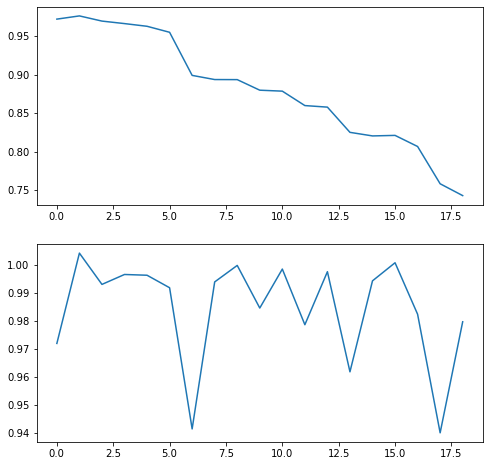

In [12]:
fig, ax = plt.subplots(2, figsize=(8, 8))

ax[0].plot(static_percent_res)
ax[1].plot(seq_percent_res)

# 90% residual ~ 12  features

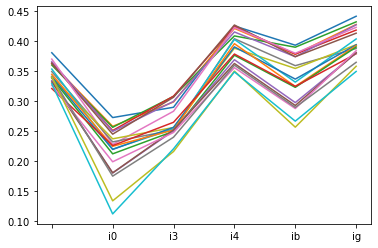

In [13]:
for i in crs:
    i['f1-score'][:6].plot()

## Iterative breadth-first pop

In [14]:
import itertools

In [15]:
epochs = 20
labels = data.iloc[:, [984]].to_numpy().reshape(-1, )
n = len(all_tf)
crs = []
static_percent_res = []
seq_percent_res = []
arrays = []

In [16]:
# rerun this cell to reset pops in all_tf_list
cpg_tf = ['envelope_5', 'integrals_pos_83', 'integrals_57']
fla_tf = ['integrals_pos_64', 'duration_3', 'integrals_pos_15']
fsl_tf = ['integrals_pos_15', 'integrals_pos_13', 'integrals_pos_19']
lps_tf = ['power_119', 'envelope_5', 'integrals_pos_39']
p3k_tf = ['duration_4', 'median_peak_amp', 'integrals_pos_35']
pic_tf = ['integrals_pos_40', 'integrals_pos_33', 'integrals_pos_47']
r84_tf = ['integrals_pos_24', 'integrals_pos_88', 'peak2rms']
tnf_tf = ['mean_movvar', 'time_series_3', 'std_peak2trough']

In [17]:
all_tf_list = [cpg_tf, fla_tf, fsl_tf, lps_tf, p3k_tf, pic_tf, r84_tf, tnf_tf]

In [18]:
r = 0
for e in range(3):
    for i in all_tf_list:
        i.pop() # pop least important feature
            
        d = list(itertools.chain(*all_tf_list))
        
        if len(d) == 0:
            break
            
        print(f'\nNumber of features: {len(d)}') # make sure this is working correctly
        
        cr, y_val, y_pred = one_fit(d, data, polarizations, random_state=100, verbose=True, ret=True, ret_labels=True)
        
        if r != 0:
            static_residual = cr.iloc[8, 2] / crs[0].iloc[8, 2]
            percent_residual = cr.iloc[8, 2] / crs[-1].iloc[8, 2]
        
            print(f'Static Percentange Residual {static_residual}')
            print(f'Sequential Percentage Residual: {percent_residual}')

            static_percent_res.append(static_residual)
            seq_percent_res.append(percent_residual)
            arrays.append((y_val, y_pred))
        
        r += 1
        
        crs.append(cr)


Number of features: 23
[14:54:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score      support
               0.325979  0.417668  0.366171  1415.000000
i0             0.317839  0.221347  0.260959  1143.000000
i3             0.320755  0.299706  0.309873  1021.000000
i4             0.415433  0.430449  0.422808   913.000000
ib             0.397762  0.387129  0.392373  1010.000000
ig             0.436834  0.440184  0.438503  1304.000000
accuracy       0.368498  0.368498  0.368498     0.368498
macro avg      0.369100  0.366081  0.365115  6806.000000
weighted avg   0.367720  0.368498  0.365401  6806.000000

Number of features: 22
[14:54:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rele

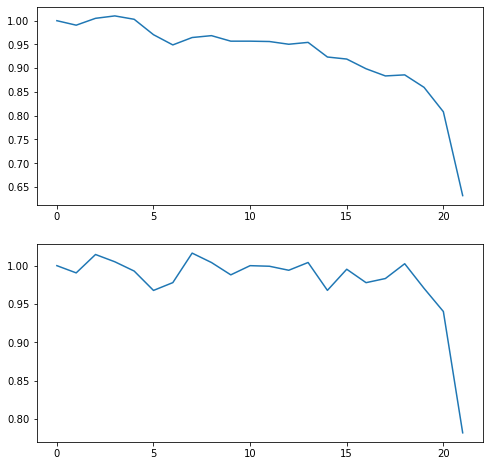

In [19]:
fig2, ax2 = plt.subplots(2, figsize=(8,8))

ax2[0].plot(static_percent_res)
ax2[1].plot(seq_percent_res)

# threshold ~ 7 features

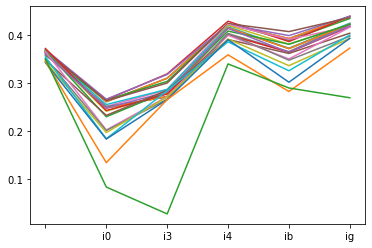

In [20]:
for i in crs:
    i['f1-score'][:6].plot()

In [41]:
model = xgb.XGBClassifier(
    tree_method='gpu_hist', 
    use_label_encoder=False,
    sampling_method='gradient_based',
    max_depth=10
)

X, y = data.iloc[:, [i for i in range(984)]].to_numpy(), data.iloc[:, [984]].to_numpy().reshape(-1, )
X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y, test_size=0.1, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_val)

cf_data = (y_val, y_pred)

[15:05:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


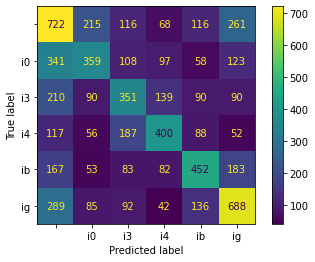

In [42]:
# 985 features
confusion_matrix = metrics.confusion_matrix(cf_data[0], cf_data[1])
metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=polarizations).plot()

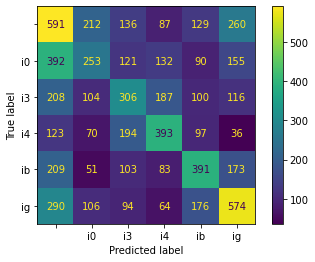

In [32]:
# 23 features
confusion_matrix = metrics.confusion_matrix(arrays[0][0], arrays[0][1])
metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=polarizations).plot()

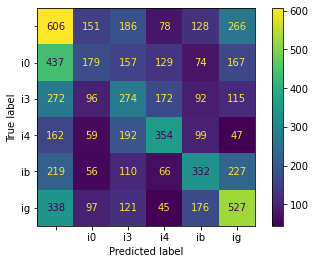

In [31]:
# 7 features
confusion_matrix = metrics.confusion_matrix(arrays[16][0], arrays[16][1])
metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=polarizations).plot()